# Notebook for running Poisson LDS with inputs
## Raveled patterns as encoding
## Stim ONLY trials, no behavior
## Increase the number of output dimensions to encode more information

In [1]:
from scipy.linalg import block_diag
import autograd.numpy as np
import matplotlib.pyplot as plt
import ssm

from pathlib import Path
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from real_spike.utils import get_spike_events, kalman_filter, bin_spikes, butter_filter, plot_dynamics_2d, plot_dynamics_3d
from matplotlib import colormaps
import pandas as pd
import h5py

from scipy.ndimage import gaussian_filter1d
from mpl_toolkits.mplot3d import Axes3D 

import random

%matplotlib inline

# Get data

In [2]:
f = h5py.File("/home/clewis/wasabi/reaganbullins2/ProjectionProject/rb50/20250127/MAT_FILES/rb50_20250127_datastruct_pt3.mat", 'r')
data = f['data']
print(data.keys())

<KeysViewHDF5 ['aligned_laser_rec_time', 'any', 'cue', 'cue_rec_time', 'cue_trial_time', 'field_id', 'field_size', 'full_field', 'grab', 'grab_ms', 'laser', 'laser_rec_time', 'laser_trial_time', 'lift', 'lift_ms', 'mouth', 'mouth_ms', 'no_success', 'pattern_fill', 'pattern_id', 'pattern_xy', 'single', 'totTime', 'trial_start']>


# Get stim only trials

In [3]:
stim_idxs = np.where(data["pattern_id"][:] > 2)[1]

# control_idxs = np.intersect1d(control_idxs, stim_idxs)
# con
stim_idxs = stim_idxs[stim_idxs > 150]
stim_idxs

array([151, 152, 153, 154, 155, 156, 157, 158, 160, 161, 162, 163, 164,
       165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177,
       179, 180, 181, 182, 183, 185, 186, 187, 188, 189, 190, 191, 192,
       193, 194, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206,
       207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 219, 220,
       221, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234,
       235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 246, 247, 248,
       249, 250, 251, 252, 253, 254, 256, 257, 258, 259, 260, 261, 262,
       263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275,
       276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 289,
       290, 291, 292, 294, 296, 297, 298, 299, 300, 301, 302, 303, 304,
       305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317,
       318, 319, 320, 321, 323, 324, 325, 326, 327, 328, 330, 331, 333,
       334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 34

In [4]:
np.unique(data["pattern_id"][0, stim_idxs])

array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15.,
       16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28.,
       29.])

In [5]:
stim_idxs.shape

(269,)

## Get relevant time information

In [6]:
laser_times = data["aligned_laser_rec_time"]
laser_times.shape

(450, 1)

## Get the AP.bin file

In [7]:
from real_spike.utils import get_sample_data, get_meta
import tifffile

In [8]:
file_path = Path("/home/clewis/wasabi/reaganbullins2/ProjectionProject/rb50/20250127/rb50_20250127_g0/rb50_20250127_g0_t0.imec0.ap.bin")
meta_path = Path("/home/clewis/wasabi/reaganbullins2/ProjectionProject/rb50/20250127/rb50_20250127_g0/rb50_20250127_g0_t0.imec0.ap.meta")

In [9]:
meta_data = get_meta(meta_path)

In [10]:
ap_data = get_sample_data(file_path, meta_data)
ap_data.shape

(385, 166298223)

## Get conversion params

In [11]:
vmax = float(meta_data["imAiRangeMax"])
# get Imax
imax = float(meta_data["imMaxInt"])
# get gain
gain = float(meta_data['imroTbl'].split(sep=')')[1].split(sep=' ')[3])

In [12]:
vmax

0.6

In [13]:
imax

512.0

In [14]:
gain

500.0

# Get trials

In [15]:
def get_trials(idxs, bin_size):
    
    model_data = list()
    
    for i in tqdm(idxs):
        trial_no = i
        # get time points in ap space
        t = 50
        start_time = int((laser_times[trial_no, 0] - t) / 1_000 * 30_000)
        
        # get end of behavior = mouth (260ms) + 300ms 
        stim_t = 5
        t2 = 50
        end_time = int((laser_times[trial_no, 0] + stim_t + t2) / 1_000 * 30_000)
    
        trial = ap_data[:150, start_time:end_time]
    
        conv_data = 1e6 * trial / vmax / imax / gain
    
        filt_data = butter_filter(conv_data, 1_000, 30_000)
    
        c_start = int(laser_times[trial_no, 0] / 1_000 * 30_000)
        m_start = c_start - (30 * 2000)
        trial_median = ap_data[:150, m_start:c_start]
    
        trial_median = 1e6 * trial_median / vmax / imax / gain
        trial_median = butter_filter(trial_median, 1_000, 30_000)
        
        median = np.median(trial_median, axis=1)
    
        spike_ixs, counts = get_spike_events(filt_data, median)
        
        a = np.zeros((filt_data.shape[0], filt_data.shape[1]))
    
        for i, sc in enumerate(spike_ixs):
            a[i, sc] = 1
    
        b = bin_size * 30 # 30ms per bin
        binned_spikes = bin_spikes(a, b)

        model_data.append(np.asarray(binned_spikes.T, dtype=int))
        
    return model_data

In [16]:
bin_size = 1

In [17]:
# model_data = get_trials(stim_idxs, bin_size)

In [18]:
# save as a pickle file 
import pickle

In [19]:
filename = f"/home/clewis/repos/realSpike/data/rb50_20250127/plds_stim/{bin_size}ms_data.pkl"
# with open(filename, "wb") as file:
#     pickle.dump(model_data, file)

In [20]:
with open(filename, "rb") as file:
    model_data = pickle.load(file)

# Design the input matrix

In [21]:
# get the pattern types

In [22]:
p_ids = np.unique(data["pattern_id"][0, stim_idxs])

p_ids

array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15.,
       16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28.,
       29.])

In [23]:
p_ids.shape

(27,)

## Get colors for plotting

In [24]:
c = [
    "maroon",
    "deeppink",
    "palevioletred", 
    "blue", 
    "orange", 
    "green", 
    "red", 
    "purple", 
    "brown", 
    "pink",
    "turquoise", 
    "olive", 
    "cyan", 
    "gold", 
    "lime", 
    "navy", 
    "magenta",
    "teal", 
    "royalblue", 
    "darkgreen",
    "dimgray",
    "darkgoldenrod",
    "midnightblue",
    "plum",
    "lime",
    "cadetblue",
    "steelblue",
    "peru"
]

In [25]:
len(c)

28

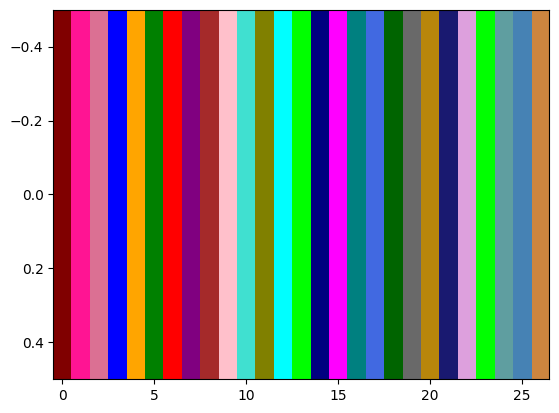

In [26]:
from matplotlib.colors import ListedColormap

cmap = ListedColormap(c)

plt.imshow(np.arange(27).reshape(1,-1), aspect="auto", cmap=cmap)

# Create encodings 

##  Reconstruct patterns

In [27]:
mat = loadmat("/home/clewis/wasabi/reaganbullins2/ProjectionProject/rb50/20250127/MAT_FILES/rb50_20250127_datastruct_pt2.mat")
mat = mat['data']

print(mat.dtype.names)

('totTime', 'cue', 'laser', 'trial_start', 'cue_rec_time', 'cue_trial_time', 'laser_rec_time', 'laser_trial_time', 'field_size', 'pattern_xy', 'field_id', 'full_field', 'pattern_id', 'pattern_fill', 'lift_ms', 'lift', 'grab_ms', 'grab', 'mouth_ms', 'mouth', 'single', 'any', 'no_success')


In [28]:
data_struct = mat[0, 0]  # MATLAB structs are 2D arrays even if 1x1
data2 = {field: data_struct[field] for field in mat.dtype.names}

In [29]:
# visualize the patterns again
pattern_ids = list(np.unique(data2['pattern_id']))
len(pattern_ids)

30

In [30]:
from scipy.ndimage import zoom

In [31]:
reshape_size = 12

In [32]:
pattern_ids = list(np.unique(data2['pattern_id']))
all_patterns = list()
# pattern 0 = no laser
#all_patterns.append(np.zeros((12, 12)))
# pattern 1 = full field
#all_patterns.append(np.ones((12, 12)))
# pattern 2 = empty field 
#all_patterns.append(np.zeros((12, 12)))
for p_id in pattern_ids[3:]:
    ix = np.where(data2['pattern_id'] == p_id)[0][0].astype(np.int32)
    pattern = np.zeros((data2['pattern_xy'][ix][0].astype(np.int32), data2['pattern_xy'][ix][1].astype(np.int32)))
    # use the pattern fill to set elements to one
    object_ref = data2['pattern_fill'][0][ix]
    for x, y in zip(object_ref[:, 0], object_ref[:, 1]):
        pattern[x.astype(np.int32)-1, y.astype(np.int32)-1] = 1

    pattern = zoom(pattern, (reshape_size / pattern.shape[0], reshape_size / pattern.shape[1]), order=0)

    all_patterns.append(pattern)


In [33]:
len(all_patterns)

27

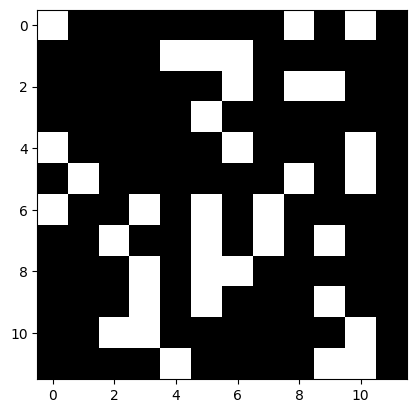

In [35]:
plt.imshow(all_patterns[0], cmap="binary")

In [29]:
model_data[0].shape

(105, 150)

In [39]:
inputs = list()
colors = list()
for i, d in zip(stim_idxs, model_data):
    # get the pattern id 
    p_id = int(data["pattern_id"][0][i]) - 3

    colors.append(c[p_id])

    encoding = all_patterns[p_id].ravel() 

    # stack the encoding for every timepoint (each bin)
    nput = np.zeros((d.shape[0], reshape_size**2))

    for z in range(5):
        nput[50 + z] = encoding

    inputs.append(nput)

In [40]:
inputs[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(105, 144))

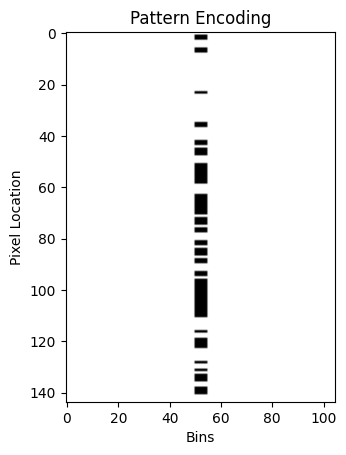

In [45]:
plt.imshow(inputs[0].T, cmap="binary")
plt.title("Pattern Encoding")
plt.xlabel("Bins")
plt.ylabel("Pixel Location")
plt.show()

# Fit the model

In [46]:
state_dim = 8
obs_dim = model_data[0].shape[1] 

plds = ssm.LDS(obs_dim, state_dim, M=144, emissions="poisson", emission_kwargs=dict(link="softplus"))

elbos, q = plds.fit(model_data, inputs=inputs, method="laplace_em", num_iters=5)

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

# Visualize the results

In [33]:
# plot my elbos

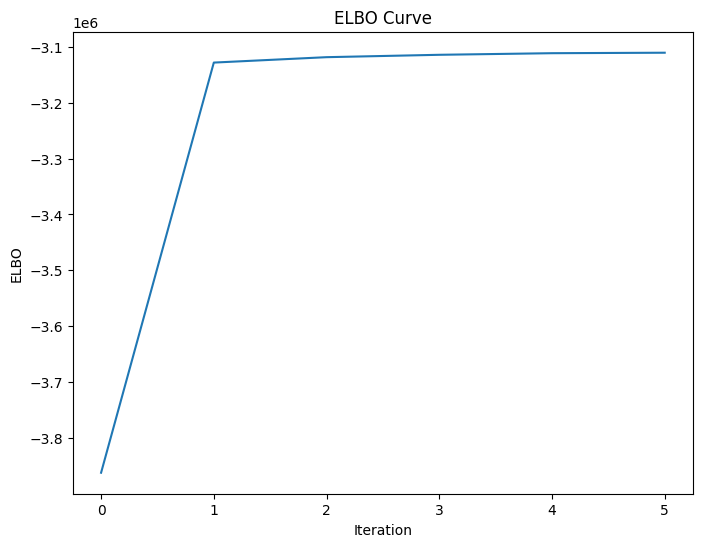

In [47]:
plt.figure(figsize=(8, 6))

plt.plot(elbos)

plt.xlabel("Iteration")
plt.ylabel("ELBO")

plt.title("ELBO Curve")

plt.show()

## Dynamics

In [48]:
A_est = plds.dynamics.A
b_est = plds.dynamics.b

In [49]:
from matplotlib.patches import Patch

In [50]:
state_means = q.mean_continuous_states

In [51]:
custom_patches = [Patch(facecolor=c[int(i)-3], edgecolor='black', label=f'{int(i)}') for i in p_ids]

# Eigenvalue Decomposition on `A`

In [52]:
A_est

array([[ 0.191612  ,  0.01880654, -0.04030755, -0.02195092, -0.02125918,
         0.0072597 ,  0.0058744 ,  0.03547581],
       [ 0.01450458,  0.19038486,  0.03201758,  0.01059425, -0.01786446,
         0.03729064, -0.01654961, -0.01477874],
       [-0.0034495 , -0.00471013,  0.21926258,  0.00454642,  0.00799516,
         0.01046693, -0.03818789,  0.00158282],
       [-0.01852074, -0.02682045,  0.01288911,  0.18994832,  0.01951202,
        -0.00946619, -0.00156931, -0.00880088],
       [-0.04894711, -0.01184037,  0.08953239,  0.05773624,  0.26107284,
        -0.05125418, -0.00305817, -0.00765421],
       [-0.03377406, -0.020469  ,  0.03813856,  0.02734169,  0.0360491 ,
         0.09644985, -0.0123795 , -0.02013352],
       [ 0.01781499,  0.01920159, -0.09147369,  0.00786758,  0.0215685 ,
        -0.03821194,  0.21813617,  0.06020705],
       [ 0.05335902,  0.03287702, -0.07941539, -0.04146555, -0.01177409,
         0.00229703,  0.08410918,  0.19907454]])

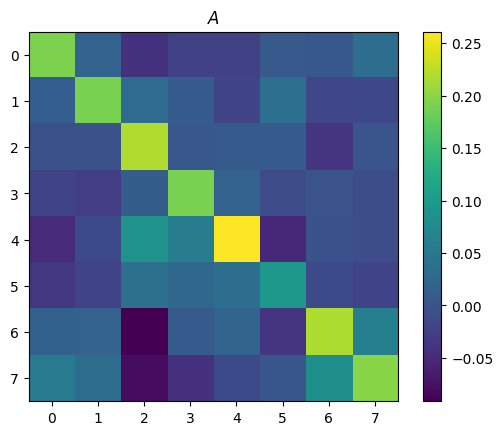

In [92]:
plt.title("$A$")

plt.imshow(A_est)

plt.colorbar()

plt.savefig("/home/clewis/repos/realSpike/data/rb50_20250127/plds_stim/pixel/A_matrix.png")

plt.show()

In [54]:
eigvals, eigvecs = np.linalg.eig(A_est)

eigvals

array([0.33226137+0.j        , 0.26647989+0.j        ,
       0.21126577+0.j        , 0.18099806+0.01541136j,
       0.18099806-0.01541136j, 0.16280359+0.j        ,
       0.11556721+0.00240403j, 0.11556721-0.00240403j])

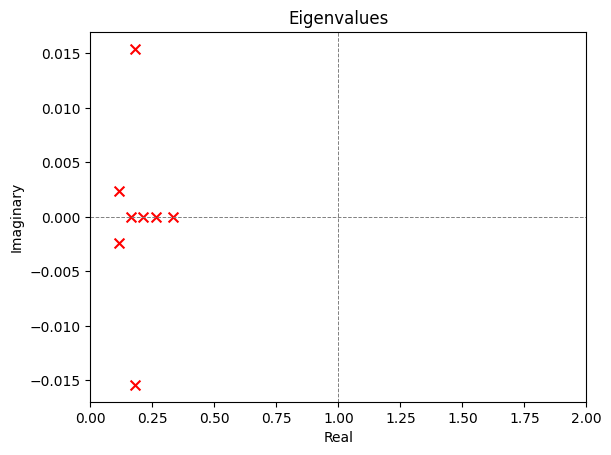

In [91]:
plt.axhline(0, color='gray', linestyle='--', linewidth=0.7)
plt.axvline(1, color='gray', linestyle='--', linewidth=0.7)

a = np.exp(eigvals)

#b = np.log(eigvals)

plt.scatter(eigvals.real, eigvals.imag, c='red', s=50, marker="x")

plt.xlim((0, 2))

plt.title("Eigenvalues")

plt.xlabel("Real")
plt.ylabel("Imaginary")

plt.savefig("/home/clewis/repos/realSpike/data/rb50_20250127/plds_stim/pixel/eigenvalues.png")

plt.show()


# Plotting B

In [56]:
B = plds.dynamics.params[2][0]

In [57]:
B.shape

(8, 144)

In [72]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

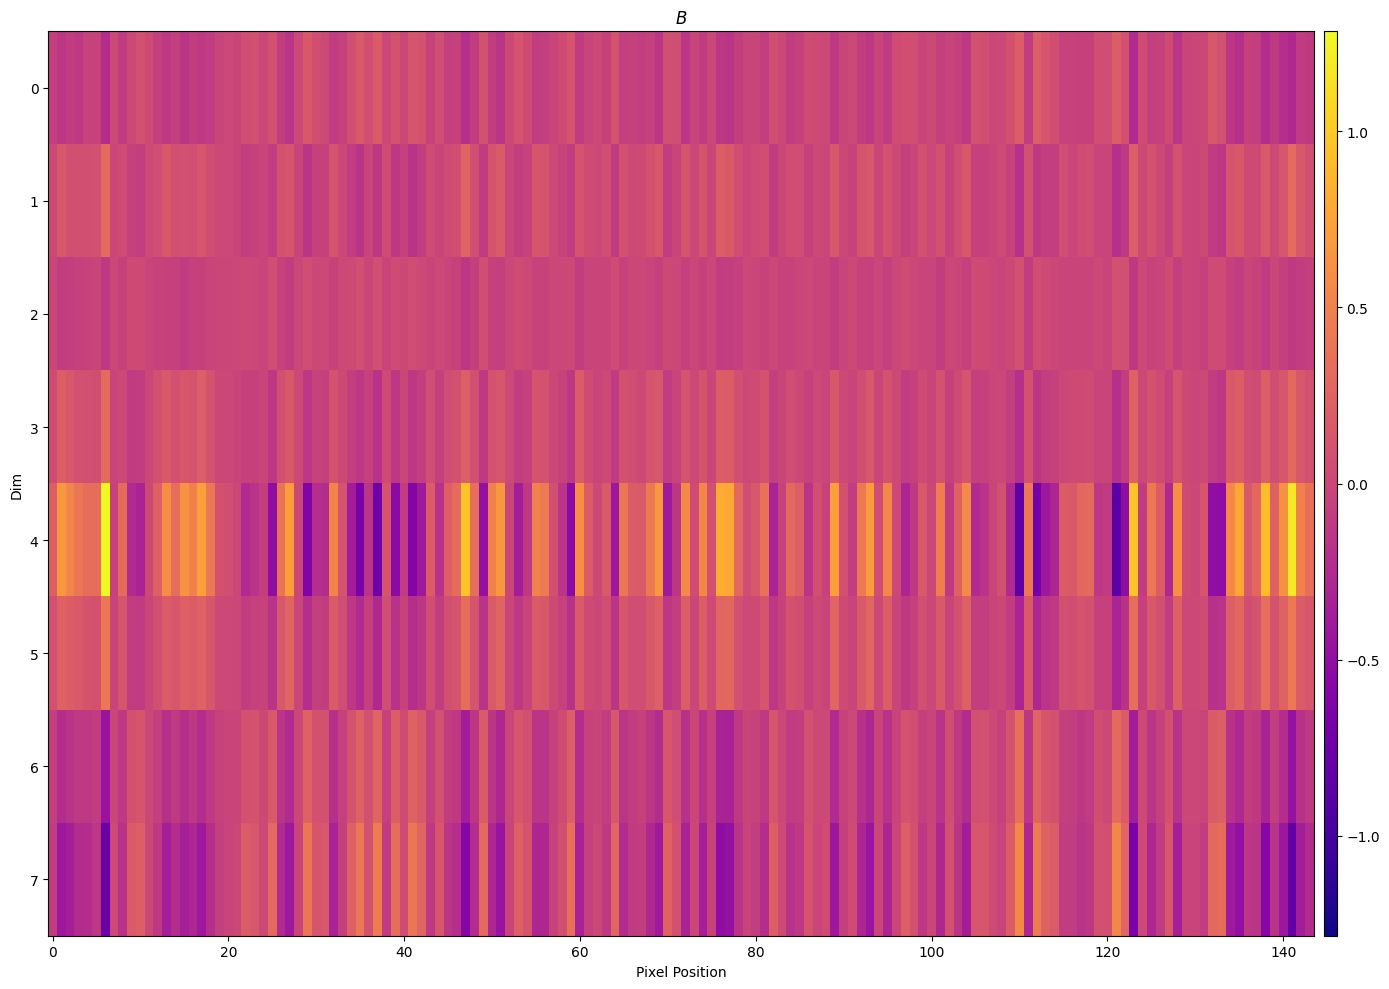

In [392]:
plt.figure(figsize=(14, 10))

plt.title("$B$")
plt.ylabel("Dim")
plt.xlabel("Pixel Position")


ax = plt.gca()
im = ax.imshow(B, cmap="plasma", aspect='auto', norm=CenteredNorm())
    
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.10)
   
plt.colorbar(im, cax=cax)

#plt.yticks([i for i in range(0, 144)], [f"Pixel {i}" for i in range(0, 144)])

plt.tight_layout()

plt.savefig("/home/clewis/repos/realSpike/data/rb50_20250127/plds_stim/pixel/B_matrix.png")

plt.show()

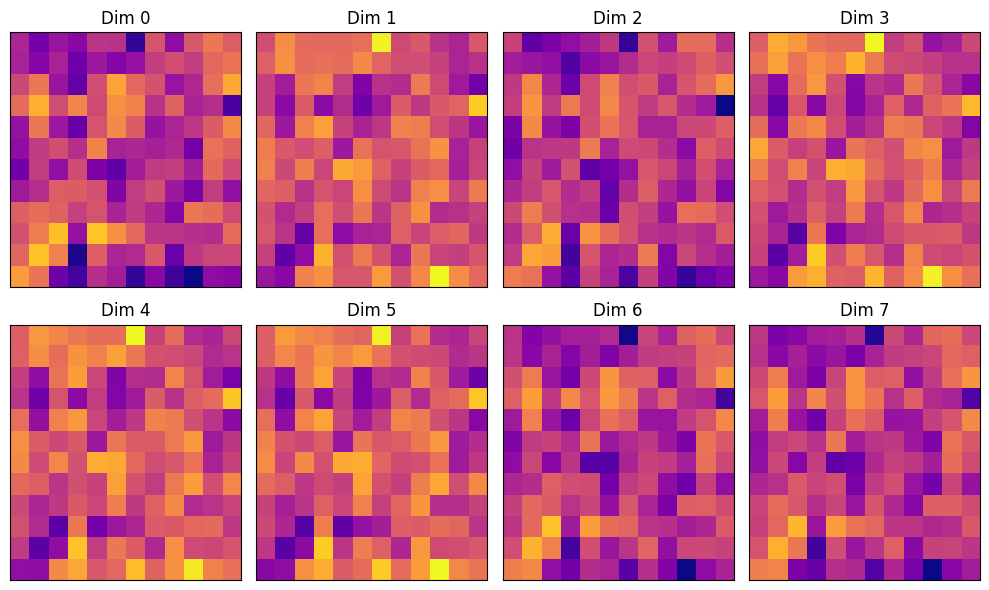

In [383]:
fig, axes = plt.subplots(2, 4, figsize=(10, 6))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i in range(8):
    ax = axes[i]
    ax.matshow(B[i].reshape(12, 12), cmap='plasma', aspect='auto', norm=CenteredNorm())
    # Create a Rectangle patch with the same dimensions as the image
  #  rect = patches.Rectangle((0, 0), data[i].shape[1] - 1, data[i].shape[0] - 1, linewidth=1, edgecolor='black', facecolor='none')
    
    # Add the patch to the axes
 #   ax.add_patch(rect)
    ax.set_title(f'Dim {i}')
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
#    ax.axis('off')  # Turn off axis

plt.tight_layout()

#plt.savefig("/home/caitlin/repos/holo-nbs/sparse_regression.png")
plt.show()

# Run lasso regression 

z_{t+1} = Az_t + Bu_t + b

In [366]:
len(state_means)

269

In [408]:
from sklearn.linear_model import Lasso

In [409]:
latent_dim = Z_all.shape[1]
input_dim = U_all.shape[1]

In [424]:
B_sparse = np.zeros((latent_dim, input_dim))
alpha = 0.08  # Lasso regularization

for i in range(latent_dim):
    lasso = Lasso(alpha=alpha)
    lasso.fit(U_all, Z_all[:, i])
    B_sparse[i, :] = lasso.coef_

Text(0.5, 1.0, '$B$')

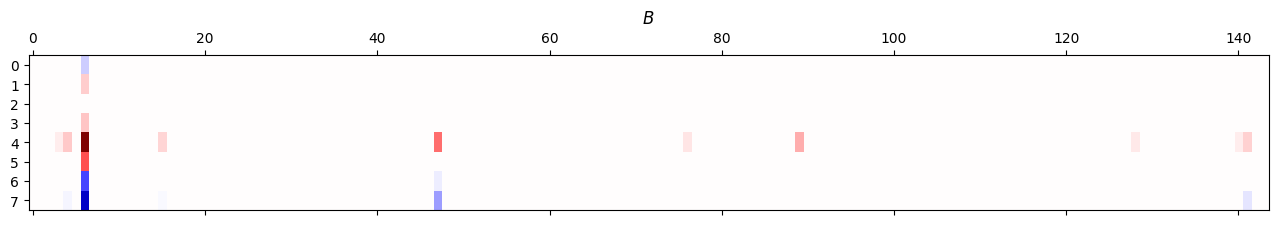

In [425]:
plt.matshow(B_sparse, cmap='seismic', aspect='auto', norm=CenteredNorm())

plt.title("$B$")

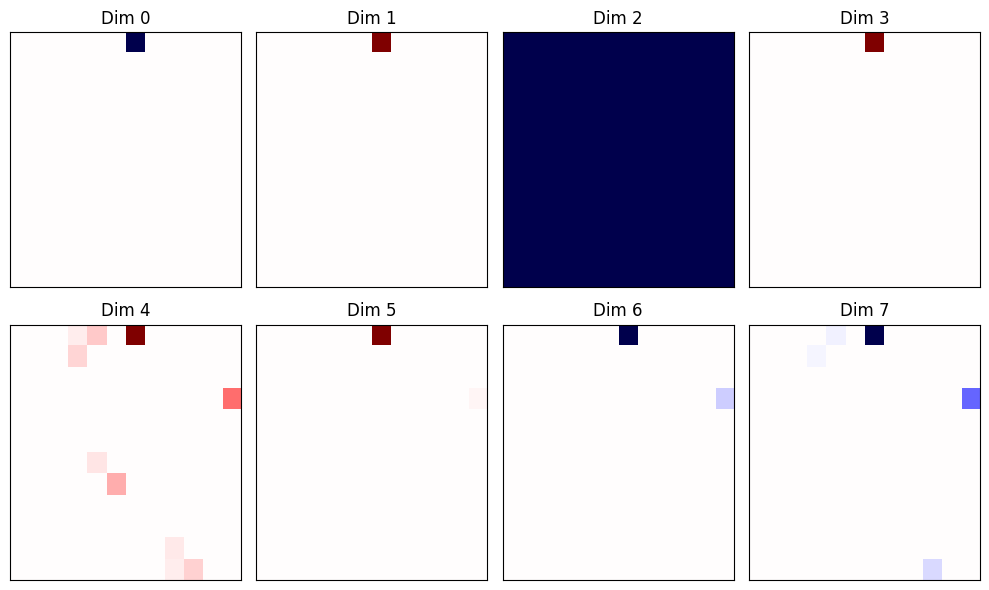

In [426]:
fig, axes = plt.subplots(2, 4, figsize=(10, 6))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i in range(8):
    ax = axes[i]
    ax.matshow(B_sparse[i].reshape(12, 12), cmap='seismic', aspect='auto', norm=CenteredNorm())
    # Create a Rectangle patch with the same dimensions as the image
  #  rect = patches.Rectangle((0, 0), data[i].shape[1] - 1, data[i].shape[0] - 1, linewidth=1, edgecolor='black', facecolor='none')
    
    # Add the patch to the axes
 #   ax.add_patch(rect)
    ax.set_title(f'Dim {i}')
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
#    ax.axis('off')  # Turn off axis

plt.tight_layout()

#plt.savefig("/home/caitlin/repos/holo-nbs/sparse_regression.png")
plt.show()